# Various imports

In [238]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [239]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [240]:
from lightgbm import LGBMRegressor, plot_importance

In [241]:
import pickle # => Might want to use cPickle

In [242]:
df = pd.read_csv("data/train.csv")
pd.set_option('display.max_columns', None)

# Outliers removing

In [243]:
df = df[(np.abs(df["temp"] - df["atemp"]) < 10)] # Removes values where the difference between real and felt temperature is too high

# Split

In [244]:
# X = df.drop(["count", "registered", "casual", "season", "holiday", "workingday"], axis=1) # , "temp", "atemp"
# y = df["count"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [245]:
date_mask = ((df["datetime"] >= "2012-09-01") & (df["datetime"] <= "2012-12-31"))
X = df.drop(["registered", "casual", "season", "holiday", "workingday"], axis=1)

X_train = X[~date_mask].drop(["count"], axis=1)
y_train = X[~date_mask]["count"]

X_test = X[date_mask].drop(["count"], axis=1)
y_test = X[date_mask]["count"]

# Pipeline

## Custom Transformers

In [246]:
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
from model_api.app.custom_transformers import DateParser

## Preprocessor

In [247]:
preprocessor = make_column_transformer(
    (DateParser(), ["datetime"]),
    # (OneHotEncoder(), ["season"]),
    remainder="passthrough"
)

# Model

In [248]:
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    r2 = r2_score(actual, pred)
    return mae, np.sqrt(mse), r2

In [249]:
model = Pipeline([("preprocessor", preprocessor), ("model", LGBMRegressor())])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dateparser', DateParser(),
                                                  ['datetime']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['season'])])),
                ('model', LGBMRegressor())])

In [250]:
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
mae, rmse, r2 = eval_metrics(y_test, y_pred)
print(f"MAE: {mae}\nRMSE: {rmse}\nR2: {r2}")

MAE: 49.66686930794539
RMSE: 75.34647404099542
R2: 0.8777637642565848


In [251]:
# from xgboost import plot_importance
# plot_importance(model["model"], ax=model["preprocessor"].get_feature_names_out())

In [252]:
# model["model"].feature_importances_
model["preprocessor"].get_feature_names_out()

array(['dateparser__datetime', 'onehotencoder__season_1',
       'onehotencoder__season_2', 'onehotencoder__season_3',
       'onehotencoder__season_4', 'remainder__holiday',
       'remainder__workingday', 'remainder__weather', 'remainder__temp',
       'remainder__atemp', 'remainder__humidity', 'remainder__windspeed'],
      dtype=object)

In [253]:
df[["windspeed", "holiday"]].columns

Index(['windspeed', 'holiday'], dtype='object')

In [254]:
raise

RuntimeError: No active exception to reraise

In [ ]:
result = permutation_importance(model, X_test, y_test, n_repeats=10)

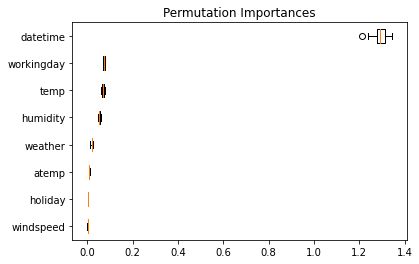

In [ ]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx]
)
ax.set_title("Permutation Importances")
plt.show()

In [ ]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [ ]:
fig = px.scatter(x=X_test["datetime"], y=np.abs(y_test - y_pred), color=y_test - y_pred > 0)#, color=y_test) # df.loc[X_test.index]["count"]
fig.update_layout(
  yaxis_title="Valeur rééle - valeur prédite", xaxis_title="Date", title=None, paper_bgcolor='rgba(0,0,0,0)',
  plot_bgcolor='rgba(0,0,0,0)', xaxis={"gridcolor": '#609a92'}, yaxis={"gridcolor": '#609a92'},
  # coloraxis_colorbar_title="Vélo empruntés")
  legend_title_text="Prédiction trop basse")
fig.write_image("velos.png", format="png", height=720, width=1280)
fig.show()

In [ ]:
fig = px.box(x=result.importances_mean[sorted_idx].T, y=X_test.columns[sorted_idx])
fig.update_layout(xaxis_title=None, yaxis_title=None, title=None, paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)', xaxis={"gridcolor": '#609a92'})
fig.show()
# fig.write_image("oui.png", format="png", scale=2)

In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
print(y_pred.shape, y_pred[y_pred < 0].shape)

(1823,) (0,)


## Save as pickle file

In [ ]:
pickle.dump(model, open("data/lightgbm.pkl", "wb"))

# Double Model 

## Registered model

In [ ]:
X = df.drop(["casual", "season", "holiday", "workingday", "count"], axis=1)

X_train = X[~date_mask].drop(["registered"], axis=1)
y_train = X[~date_mask]["registered"]

X_test = X[date_mask].drop(["registered"], axis=1)
y_test = X[date_mask]["registered"]

In [ ]:
model_re = Pipeline([("preprocessor", preprocessor), ("model", LGBMRegressor())])
model_re.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dateparser', DateParser(),
                                                  ['datetime'])])),
                ('model', LGBMRegressor())])

In [ ]:
y_pred = model_re.predict(X_test)
mae, rmse, r2 = eval_metrics(y_test, y_pred)
print(f"MAE: {mae}\nRMSE: {rmse}\nR2: {r2}")

MAE: 40.913355042278546
RMSE: 62.54841451417858
R2: 0.8865507044100843


## Casual model

In [ ]:
X = df.drop(["registered", "season", "holiday", "workingday", "count"], axis=1)

X_train = X[~date_mask].drop(["casual"], axis=1)
y_train = X[~date_mask]["casual"]

X_test = X[date_mask].drop(["casual"], axis=1)
y_test = X[date_mask]["casual"]

In [ ]:
model_ca = Pipeline([("preprocessor", preprocessor), ("model", LGBMRegressor())])
model_ca.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dateparser', DateParser(),
                                                  ['datetime'])])),
                ('model', LGBMRegressor())])

In [ ]:
y_pred = model_ca.predict(X_test)
mae, rmse, r2 = eval_metrics(y_test, y_pred)
print(f"MAE: {mae}\nRMSE: {rmse}\nR2: {r2}")

MAE: 11.89284631614057
RMSE: 20.410499100928064
R2: 0.8616637994138227


## Combining both

In [ ]:
raise
y_pred = clf.predict(X_test)
mae, rmse, r2 = eval_metrics(y_test, y_pred)
print(f"MAE: {mae}\nRMSE: {rmse}\nR2: {r2}")

RuntimeError: No active exception to reraise

In [ ]:
print(y_pred.shape, y_pred[y_pred < 0].shape)

(1823,) (29,)
